## Importing the libraries

In [1]:
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/Users/divyanshpurohit/Desktop/Projects/Jupyter NB/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Dataset: NDBC data for Station 51101, from 2013 to 2017

In [2]:
df_2013 = pd.read_csv("./data/51101h2013.txt", sep="\s+", index_col=False)
df_2014 = pd.read_csv("./data/51101h2014.txt", sep="\s+", index_col=False)
df_2015 = pd.read_csv("./data/51101h2015.txt", sep="\s+", index_col=False)
df_2016 = pd.read_csv("./data/51101h2016.txt", sep="\s+", index_col=False)
df_2017 = pd.read_csv("./data/51101h2017.txt", sep="\s+", index_col=False)
df_2013 = df_2013.iloc[::-1].reset_index(drop=True)
df_2014 = df_2014.iloc[::-1].reset_index(drop=True)
df_2015 = df_2015.iloc[::-1].reset_index(drop=True)
df_2016 = df_2016.iloc[::-1].reset_index(drop=True)
df_2017 = df_2017.iloc[::-1].reset_index(drop=True)

In [3]:
df = pd.concat([df_2017, df_2016, df_2015, df_2014, df_2013], ignore_index=True)
df = df[df["#YY"] != "#yr"]
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2017,12,31,22,50,134,5.6,7.1,1.59,13.79,6.74,320,1019.4,22.7,23.6,999.0,99.0,99.00
1,2017,12,31,21,50,116,5.4,7.2,1.53,13.79,6.81,310,1020.5,22.6,23.5,999.0,99.0,99.00
2,2017,12,31,20,50,132,5.3,6.9,1.60,14.81,7.17,323,1021.0,22.6,23.5,999.0,99.0,99.00
3,2017,12,31,19,50,114,4.3,5.4,1.54,14.81,6.85,300,1021.3,22.6,23.4,999.0,99.0,99.00
4,2017,12,31,18,50,114,5.9,7.0,1.39,13.79,6.72,316,1020.8,22.2,23.4,999.0,99.0,99.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40717,2013,01,01,03,50,358,10.4,12.3,4.08,14.81,8.50,326,1019.3,22.1,24.1,15.8,99.0,99.00
40718,2013,01,01,02,50,351,9.9,12.1,4.27,14.81,9.09,327,1018.7,22.3,24.1,16.0,99.0,99.00
40719,2013,01,01,01,50,357,9.4,11.8,4.03,14.81,9.16,330,1017.9,22.4,24.1,16.6,99.0,99.00
40720,2013,01,01,00,50,345,10.3,12.0,3.71,14.81,8.79,314,1017.4,22.1,24.1,17.3,99.0,99.00


In [4]:
df['Date'] = df['#YY'] + '-' + df['MM'] + '-' + df['DD'] + ' ' + df['hh'] + ':' + df['mm']
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

cols = ['#YY', 'DD', 'mm']
df.drop(columns=cols, inplace=True)
df = df.apply(lambda x: pd.to_numeric(x), axis=0)
df.head()

,MM,hh,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
Date,,,,,,,,,,,,,,,
2017-12-31 22:50:00,12,22,134,5.6,7.1,1.59,13.79,6.74,320,1019.4,22.7,23.6,999.0,99.0,99.0
2017-12-31 21:50:00,12,21,116,5.4,7.2,1.53,13.79,6.81,310,1020.5,22.6,23.5,999.0,99.0,99.0
2017-12-31 20:50:00,12,20,132,5.3,6.9,1.60,14.81,7.17,323,1021.0,22.6,23.5,999.0,99.0,99.0
2017-12-31 19:50:00,12,19,114,4.3,5.4,1.54,14.81,6.85,300,1021.3,22.6,23.4,999.0,99.0,99.0
2017-12-31 18:50:00,12,18,114,5.9,7.0,1.39,13.79,6.72,316,1020.8,22.2,23.4,999.0,99.0,99.0


In [5]:
df["Temp_diff"] = df["ATMP"] - df["WTMP"]

In [6]:
# df.dtypes

## Looking into Feature Correlation

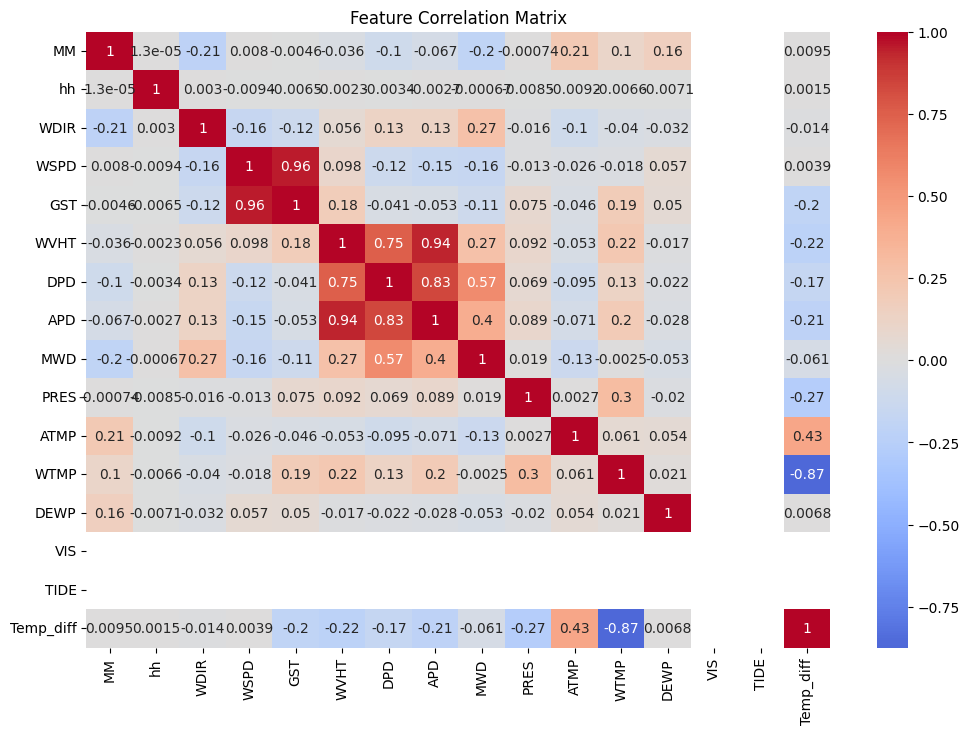

WVHT         1.000000
APD          0.941039
DPD          0.745360
MWD          0.268386
WTMP         0.217308
GST          0.184002
WSPD         0.097812
PRES         0.091973
WDIR         0.056393
hh          -0.002273
DEWP        -0.017401
MM          -0.036482
ATMP        -0.053023
Temp_diff   -0.222261
VIS               NaN
TIDE              NaN
Name: WVHT, dtype: float64


In [7]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

print(corr['WVHT'].sort_values(ascending=False))

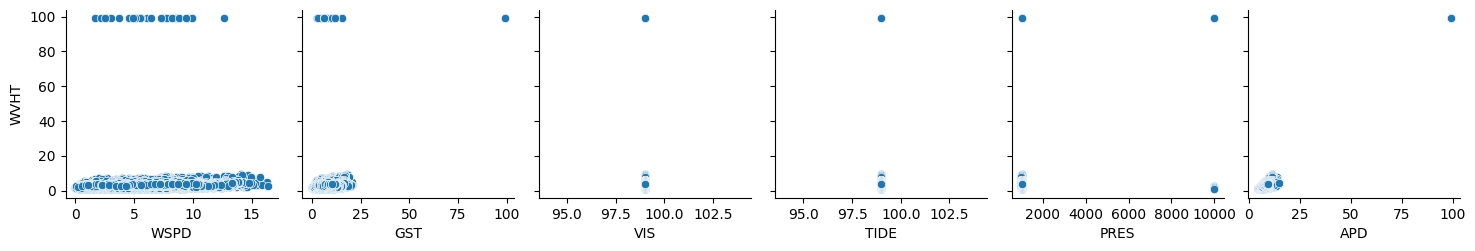

In [8]:
sns.pairplot(df, x_vars=['WSPD', 'GST', 'VIS', 'TIDE', 'PRES', 'APD'], y_vars='WVHT')
plt.show()

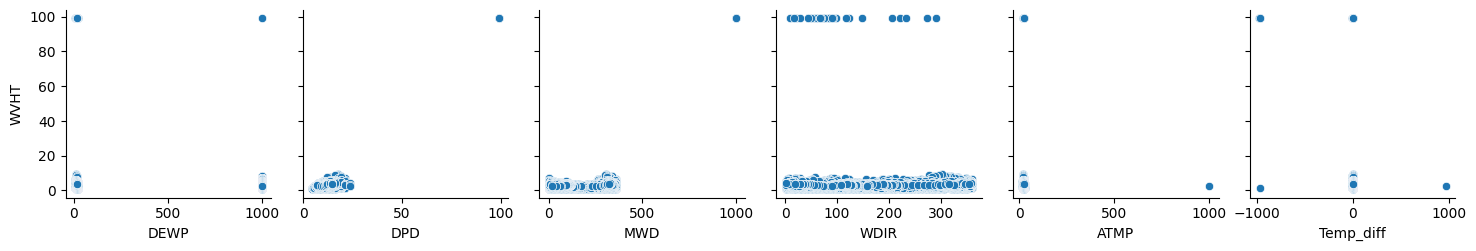

In [9]:
sns.pairplot(df, x_vars=['DEWP', 'DPD', 'MWD', 'WDIR', 'ATMP', 'Temp_diff'], y_vars='WVHT')
plt.show()

## Capturing Non-Linear Feature Correlation

In [10]:
from sklearn.feature_selection import mutual_info_regression

X = df.drop(columns=['WVHT'])
y = df['WVHT']

X = X.fillna(0)

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

APD          0.360959
MM           0.237353
GST          0.201005
WSPD         0.181956
ATMP         0.143102
WTMP         0.135207
DPD          0.134681
MWD          0.125378
Temp_diff    0.087577
WDIR         0.074687
PRES         0.073498
DEWP         0.072117
TIDE         0.002784
VIS          0.001770
hh           0.000000
dtype: float64


In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

APD          0.618851
DPD          0.201292
MWD          0.138196
GST          0.029168
WDIR         0.002279
Temp_diff    0.002201
PRES         0.001638
WSPD         0.001436
ATMP         0.001341
WTMP         0.001145
MM           0.001141
DEWP         0.000664
hh           0.000650
VIS          0.000000
TIDE         0.000000
dtype: float64


## A look into the data

In [12]:
df.describe()

,MM,hh,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,Temp_diff
count,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.0,40718.0,40718.000000
mean,6.379144,11.536176,115.546834,6.746716,8.365905,2.426634,10.925272,7.189501,181.545803,1019.790176,23.848347,25.163532,679.603696,99.0,99.0,-1.315185
std,3.506945,6.906457,89.265431,2.555594,3.058030,3.003133,3.839898,3.057863,124.252254,147.645114,5.266783,9.791129,459.776829,0.0,0.0,10.829351
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.830000,4.350000,4.460000,1.000000,998.800000,16.600000,20.800000,6.600000,99.0,99.0,-977.100000
25%,3.000000,6.000000,61.000000,5.100000,6.400000,1.720000,8.330000,6.060000,79.000000,1015.600000,22.300000,23.700000,20.300000,99.0,99.0,-1.700000
50%,6.000000,12.000000,81.000000,6.900000,8.400000,2.120000,10.810000,6.780000,114.000000,1017.600000,24.000000,25.000000,999.000000,99.0,99.0,-1.000000
75%,9.000000,18.000000,137.000000,8.500000,10.300000,2.780000,12.900000,7.830000,314.000000,1019.700000,25.600000,26.500000,999.000000,99.0,99.0,-0.500000
max,12.000000,23.000000,360.000000,16.400000,99.000000,99.000000,99.000000,99.000000,999.000000,9999.000000,999.000000,999.000000,999.000000,99.0,99.0,973.300000


In [13]:
df.replace([99, 999, 9999], np.nan, inplace=True)
df.drop(['VIS', 'TIDE', 'DEWP'], axis=1, inplace=True)
df.head()

,MM,hh,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,Temp_diff
Date,,,,,,,,,,,,,
2017-12-31 22:50:00,12,22,134.0,5.6,7.1,1.59,13.79,6.74,320.0,1019.4,22.7,23.6,-0.9
2017-12-31 21:50:00,12,21,116.0,5.4,7.2,1.53,13.79,6.81,310.0,1020.5,22.6,23.5,-0.9
2017-12-31 20:50:00,12,20,132.0,5.3,6.9,1.60,14.81,7.17,323.0,1021.0,22.6,23.5,-0.9
2017-12-31 19:50:00,12,19,114.0,4.3,5.4,1.54,14.81,6.85,300.0,1021.3,22.6,23.4,-0.8
2017-12-31 18:50:00,12,18,114.0,5.9,7.0,1.39,13.79,6.72,316.0,1020.8,22.2,23.4,-1.2


In [14]:
df.isna().sum()

MM             0
hh             0
WDIR         213
WSPD           0
GST            3
WVHT          36
DPD           36
APD           36
MWD          360
PRES          11
ATMP           1
WTMP           4
Temp_diff      0
dtype: int64

## Data preprocessing

### Filling the missing values with the median of the column, as these are small in number

In [15]:
cols_to_impute = ['WDIR','GST','DPD','APD','MWD','PRES','ATMP','WTMP']
for col in cols_to_impute:
    df[col] = df[col].fillna(df[col].median())

### Dropping the rows with Temp_Diff values < -50 and > +50

In [16]:
df = df[(df['Temp_diff'] > -50) & (df['Temp_diff'] < 50)]

### Dropping the rows with missing target value

In [17]:
df = df[~df["WVHT"].isna()]
df.isna().sum()

MM           0
hh           0
WDIR         0
WSPD         0
GST          0
WVHT         0
DPD          0
APD          0
MWD          0
PRES         0
ATMP         0
WTMP         0
Temp_diff    0
dtype: int64

In [18]:
df.shape

(40680, 13)

## Plotting the distribution of wave height

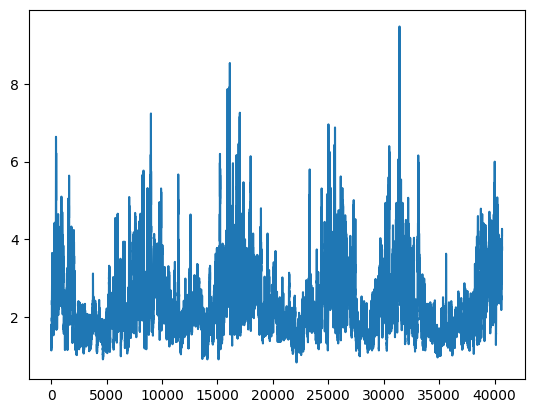

In [19]:
plt.plot(range(len(df["WVHT"])), df["WVHT"])
plt.show()

In [20]:
df.iloc[0:23]

,MM,hh,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,Temp_diff
Date,,,,,,,,,,,,,
2017-12-31 22:50:00,12,22,134.0,5.6,7.1,1.59,13.79,6.74,320.0,1019.4,22.7,23.6,-0.9
2017-12-31 21:50:00,12,21,116.0,5.4,7.2,1.53,13.79,6.81,310.0,1020.5,22.6,23.5,-0.9
2017-12-31 20:50:00,12,20,132.0,5.3,6.9,1.60,14.81,7.17,323.0,1021.0,22.6,23.5,-0.9
2017-12-31 19:50:00,12,19,114.0,4.3,5.4,1.54,14.81,6.85,300.0,1021.3,22.6,23.4,-0.8
2017-12-31 18:50:00,12,18,114.0,5.9,7.0,1.39,13.79,6.72,316.0,1020.8,22.2,23.4,-1.2
2017-12-31 17:50:00,12,17,124.0,5.5,7.1,1.43,13.79,6.81,280.0,1020.3,22.2,23.4,-1.2
2017-12-31 16:50:00,12,16,107.0,4.4,6.0,1.45,13.79,6.64,277.0,1019.7,22.0,23.4,-1.4
2017-12-31 15:50:00,12,15,105.0,6.3,7.9,1.54,13.79,6.60,282.0,1018.9,21.8,23.4,-1.6
2017-12-31 14:50:00,12,14,118.0,6.1,8.0,1.45,12.90,5.83,1.0,1018.6,21.8,23.4,-1.6


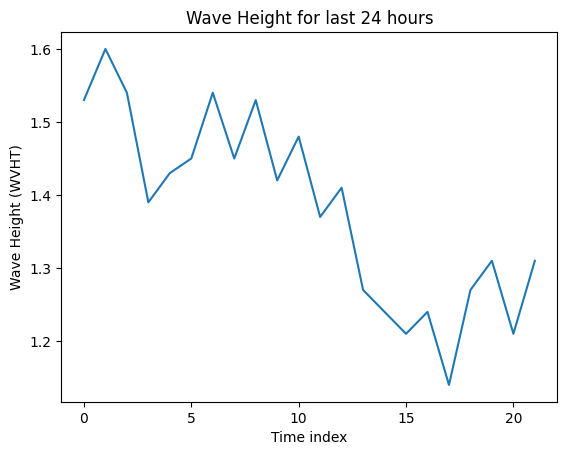

In [21]:
plt.plot(range(len(df.iloc[1:23].index)), df.iloc[1:23]["WVHT"])
plt.xlabel("Time index")
plt.ylabel("Wave Height (WVHT)")
plt.title("Wave Height for last 24 hours")
plt.show()

In [22]:
df.iloc[0:740]

,MM,hh,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,Temp_diff
Date,,,,,,,,,,,,,
2017-12-31 22:50:00,12,22,134.0,5.6,7.1,1.59,13.79,6.74,320.0,1019.4,22.7,23.6,-0.9
2017-12-31 21:50:00,12,21,116.0,5.4,7.2,1.53,13.79,6.81,310.0,1020.5,22.6,23.5,-0.9
2017-12-31 20:50:00,12,20,132.0,5.3,6.9,1.60,14.81,7.17,323.0,1021.0,22.6,23.5,-0.9
2017-12-31 19:50:00,12,19,114.0,4.3,5.4,1.54,14.81,6.85,300.0,1021.3,22.6,23.4,-0.8
2017-12-31 18:50:00,12,18,114.0,5.9,7.0,1.39,13.79,6.72,316.0,1020.8,22.2,23.4,-1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01 04:50:00,12,4,49.0,9.9,11.4,2.96,14.81,7.60,330.0,1020.1,22.4,24.6,-2.2
2017-12-01 03:50:00,12,3,68.0,10.1,11.7,3.00,14.81,7.86,336.0,1019.5,21.8,24.6,-2.8
2017-12-01 02:50:00,12,2,61.0,8.3,9.8,2.96,14.81,8.21,325.0,1018.7,22.0,24.6,-2.6


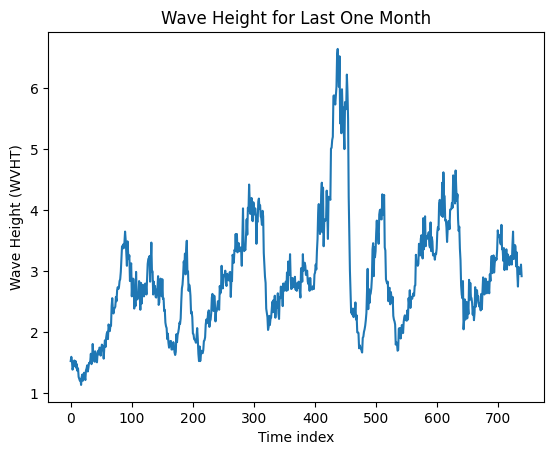

In [23]:
plt.plot(range(len(df.iloc[1:740].index)), df.iloc[1:740]["WVHT"])
plt.xlabel("Time index")
plt.ylabel("Wave Height (WVHT)")
plt.title("Wave Height for Last One Month")
plt.show()

In [24]:
features = ['MM','hh','WDIR','WSPD','GST','DPD','APD','MWD','PRES','ATMP','WTMP','Temp_diff']
target = 'WVHT'

In [25]:
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Scaling the values for LSTM

In [26]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

In [27]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, shuffle=False)

## Sequencing the Time Series Data to avoid redundant values

In [40]:
sequence_length = 24
batch_size = 32

train_dataset = timeseries_dataset_from_array(
    data=X_train_final,
    targets=y_train_final,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

val_dataset = timeseries_dataset_from_array(
    data=X_val,
    targets=y_val,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

test_dataset = timeseries_dataset_from_array(
    data=X_test_scaled,
    targets=y_test_scaled,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

In [41]:
num_train_sequences = sum(1 for _ in train_dataset)
num_val_sequences = sum(1 for _ in val_dataset)
print(num_train_sequences, num_val_sequences)

813 203


2025-10-18 16:49:35.174912: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Defining the LSTM Model

In [42]:
model = Sequential([
    Input(shape=(sequence_length, len(features))),
    LSTM(50, activation='tanh', input_shape=(sequence_length, len(features))),
    Dense(1) 
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/Users/divyanshpurohit/Desktop/Projects/Jupyter NB/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,651 (49.42 KB)

 Trainable params: 12,651 (49.42 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)

Epoch 1/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086 - mae: 0.0679 - val_loss: 0.0049 - val_mae: 0.0539
Epoch 2/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0049 - mae: 0.0500 - val_loss: 0.0084 - val_mae: 0.0785
Epoch 3/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0044 - mae: 0.0472 - val_loss: 0.0104 - val_mae: 0.0846
Epoch 4/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0043 - mae: 0.0465 - val_loss: 0.0101 - val_mae: 0.0848
Epoch 5/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0038 - mae: 0.0436 - val_loss: 0.0071 - val_mae: 0.0694
Epoch 6/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033 - mae: 0.0407 - val_loss: 0.0066 - val_mae: 0.0633
Epoch 7/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0031 - mae: 0.0395 - val_loss: 0.0053 - val_mae: 0.0568
Epoch 8/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0026 - mae: 0.0368 - val_loss: 0.0048 - val_mae: 0.0537
Epoch 9/30
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

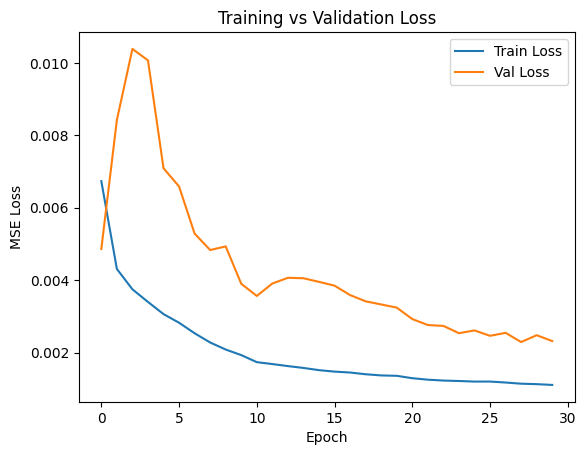

In [44]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [45]:
y_pred_scaled = model.predict(test_dataset)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled[sequence_length-1:])  # first few can't be predicted

# Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.676, MAE: 0.477, R2: 0.223


## Plotting the expected vs true values

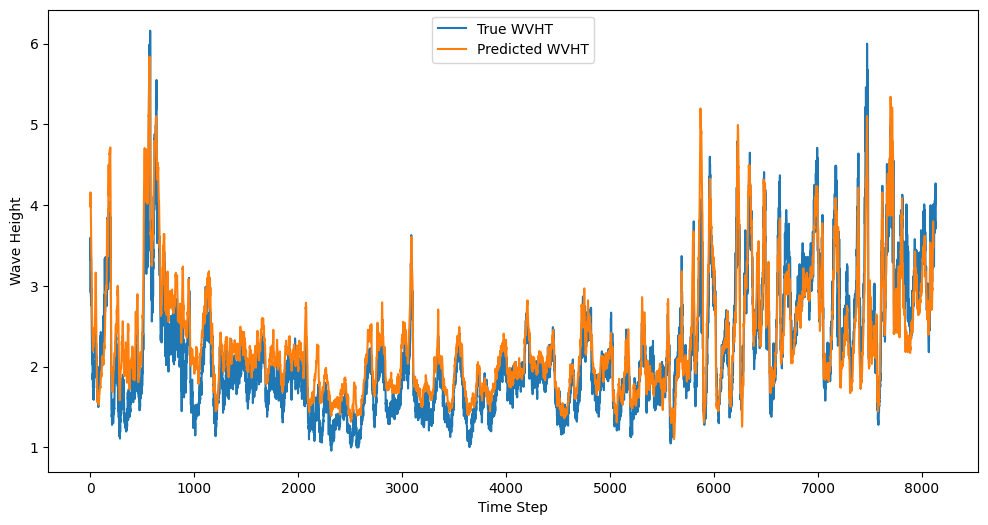

In [48]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True WVHT')
plt.plot(y_pred, label='Predicted WVHT')
plt.xlabel('Time Step')
plt.ylabel('Wave Height')
plt.legend()
plt.show()

In [36]:
# sequence length of 24 not valid:
# many outliers (data ponits) entires from a day were removed.
# a day might have less than 24 values left.

## Applying SCaPE

In [78]:
r = np.abs(y_true - y_pred)
r

array([[2.17104824],
       [2.53262711],
       [2.37530514],
       ...,
       [0.15826872],
       [0.08371325],
       [0.28764943]])

In [79]:
threshold = np.median(r)
b = (r > threshold).astype(int)

In [80]:
descriptors = X_test_scaled[sequence_length-1:]

df_scape = pd.DataFrame(descriptors, columns=features)
df_scape['b'] = b
df_scape['r'] = r
df_scape.head()

,MM,hh,WDIR,WSPD,GST,DPD,APD,MWD,PRES,ATMP,WTMP,Temp_diff,b,r
0,1.0,0.217391,0.991643,0.439024,0.441748,0.369135,0.192795,0.883008,0.592466,0.523810,0.414894,0.594059,1,2.171048
1,1.0,0.173913,0.991643,0.463415,0.436893,0.207508,0.148978,0.225627,0.575342,0.515873,0.425532,0.574257,1,2.532627
2,1.0,0.130435,0.000000,0.475610,0.451456,0.247132,0.145083,0.169916,0.561644,0.515873,0.414894,0.584158,1,2.375305
3,1.0,0.086957,0.972145,0.506098,0.480583,0.294578,0.133398,0.111421,0.541096,0.523810,0.414894,0.594059,1,2.372858
4,1.0,0.043478,0.966574,0.536585,0.500000,0.369135,0.147030,0.855153,0.523973,0.531746,0.414894,0.603960,1,2.173676


In [91]:
results = []

for col in ['MM','hh','WDIR','WSPD','GST','DPD','APD','MWD','PRES','ATMP','WTMP','Temp_diff']:
    values = df_scape[col].values
    thresholds = np.percentile(values, [25, 50, 75])

    for t in thresholds:
        subgroup = df_scape[values > t]
        if len(subgroup) < 50:
            continue

        mean_b = subgroup['b'].mean()
        mean_r = subgroup['r'].mean()
        lift = mean_b - df_scape['b'].mean()

        results.append({
            'feature': col,
            'threshold': t,
            'mean_b': mean_b,
            'mean_r': mean_r,
            'lift_b': lift,
            'support': len(subgroup)
        })

results_df = pd.DataFrame(results).sort_values('lift_b', ascending=False)
print(results_df.head(10))

   feature  threshold    mean_b    mean_r    lift_b  support
20     APD   0.301850  0.702676  0.646818  0.202738     2018
8     WDIR   0.364903  0.650249  0.620402  0.150310     2010
17     DPD   0.405109  0.642361  0.626892  0.142423     2016
19     APD   0.207400  0.624783  0.550646  0.124845     4035
23     MWD   0.866295  0.606566  0.582695  0.106627     1980
16     DPD   0.294578  0.602933  0.547854  0.102995     3614
2       MM   0.727273  0.585227  0.538338  0.085289     1584
14     GST   0.470874  0.577867  0.512415  0.077928     1997
15     DPD   0.207508  0.569008  0.511254  0.069069     5311
26    PRES   0.712329  0.566532  0.460457  0.066594     1984


In [99]:
df_scape[['b', 'r']].describe()

,b,r
count,8113.000000,8113.000000
mean,0.499938,0.436733
std,0.500031,0.504753
min,0.000000,0.000058
25%,0.000000,0.120305
50%,0.000000,0.270564
75%,1.000000,0.560935
max,1.000000,4.400701


In [93]:
def subgroup_quality(df, subgroup):
    global_mean = df[real_target].mean()
    sub_mean = subgroup[real_target].mean()
    global_prop = df[binary_target].mean()
    sub_prop = subgroup[binary_target].mean()
    
    return sub_mean - global_mean, sub_prop - global_prop

In [95]:
descriptive_features = ['MM','hh','WDIR','WSPD','GST','DPD','APD','MWD','PRES','ATMP','WTMP','Temp_diff']
binary_target = 'b'
real_target = 'r'

In [97]:
interesting_subgroups = []

for col in descriptive_features:
    thresholds = df_scape[col].quantile([0.25, 0.5, 0.75])
    for t in thresholds:
        subgroup = df_scape[df_scape[col] > t]
        if len(subgroup) < 50: 
            continue
        quality = subgroup_quality(df_scape, subgroup)
        interesting_subgroups.append((col, '>', t, quality, len(subgroup)))

interesting_subgroups.sort(key=lambda x: x[3][0], reverse=True)

for sg in interesting_subgroups[:5]:
    print(f"Subgroup: {sg[0]} {sg[1]} {sg[2]:.3f}, "f"delta_error={sg[3][0]:.3f}, delta_bad%={sg[3][1]:.3f}, size={sg[4]}")

Subgroup: APD > 0.302, delta_error=0.210, delta_bad%=0.203, size=2018
Subgroup: DPD > 0.405, delta_error=0.190, delta_bad%=0.142, size=2016
Subgroup: WDIR > 0.365, delta_error=0.184, delta_bad%=0.150, size=2010
Subgroup: MWD > 0.866, delta_error=0.146, delta_bad%=0.107, size=1980
Subgroup: APD > 0.207, delta_error=0.114, delta_bad%=0.125, size=4035


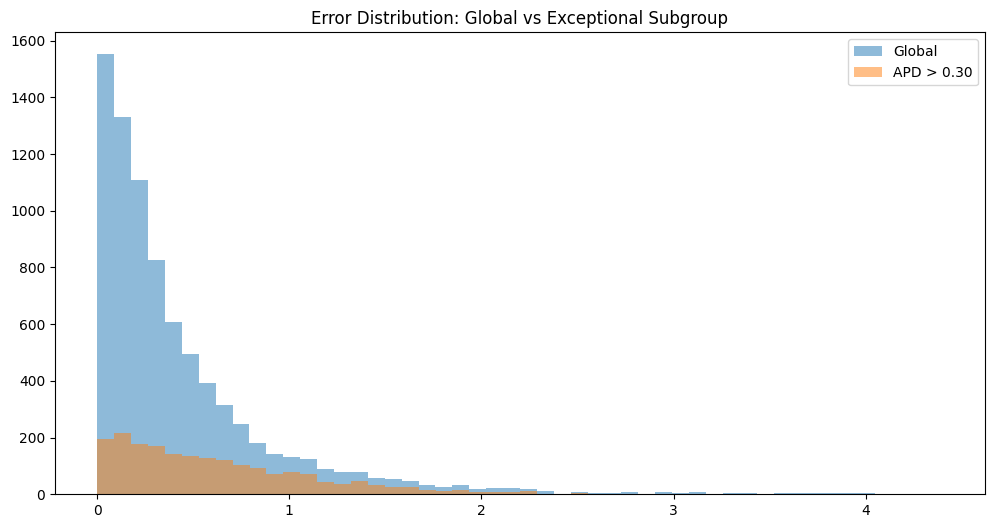

In [98]:
top_feature, op, t, _, _ = interesting_subgroups[0]
sub = df_scape[df_scape[top_feature] > t]

plt.figure(figsize=(12,6))
plt.hist(df_scape['r'], bins=50, alpha=0.5, label='Global')
plt.hist(sub['r'], bins=50, alpha=0.5, label=f'{top_feature} > {t:.2f}')
plt.legend()
plt.title('Error Distribution: Global vs Exceptional Subgroup')
plt.show()

In [100]:
interesting_subgroups[0]

('APD',
 '>',
 0.3018500486854917,
 (np.float64(0.2100856332871029), np.float64(0.2027375462328016)),
 2018)